In [250]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-5408a4cc-caf7-4a77-b13e-bd0f2f062b92',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'HtcQ8zAoCIr6jwNjF1Adyt0pQ6eIR-kURhIgm5FwCWuy'
}

configuration_name = 'os_70b37ccb259f4785bd2dabe79b709579_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df= spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkifycustomerchurnprediction-donotdelete-pr-bpmhxvpfa5y5o5'))
df.take(5)


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [313]:
# import libraries
#from pyspark.sql import SparkSession
from pyspark.sql.functions import add_months, avg, count, countDistinct, col, datediff,\
desc, expr, from_unixtime, floor, isnan, lag, lit, month, months_between,\
min, max, split, sum, udf, unix_timestamp, when, year
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window

from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler, OneHotEncoderEstimator
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from sklearn.metrics import classification_report, confusion_matrix

import os
import re
import time
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

! pip install user_agents
from user_agents import parse

import re

%matplotlib inline

from datetime import datetime

  Using cached https://files.pythonhosted.org/packages/9d/22/4d16b08db329fd440eed366d35e4dd7195c9babb4ecac5218f28081522a2/ua_parser-0.10.0-py2.py3-none-any.whl
Target directory /home/spark/shared/user-libs/python3.6/ua_parser already exists. Specify --upgrade to force replacement.
Target directory /home/spark/shared/user-libs/python3.6/ua_parser-0.10.0.dist-info already exists. Specify --upgrade to force replacement.
Target directory /home/spark/shared/user-libs/python3.6/user_agents already exists. Specify --upgrade to force replacement.
Target directory /home/spark/shared/user-libs/python3.6/user_agents-2.1.dist-info already exists. Specify --upgrade to force replacement.


In [252]:
df.count()

543705

### Explore Data
Perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

See different pages

In [253]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [254]:
# picking and looking at few confirmed user cancellation
df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates().show(10)

+------+
|userId|
+------+
|   296|
|100010|
|200002|
|    51|
|   124|
|200037|
|    54|
|   234|
|100014|
|   154|
+------+
only showing top 10 rows



In [255]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Load and Clean the Dataset

In [256]:
# check null values per column
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



In [257]:
# filter out all entries with missing names.
# they are not recording information that we will need for the model
df = df.filter(df.firstName.isNotNull())

In [258]:
# check null values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 95128|   0|        0|     0|            0|       0| 95128|    0|       0|     0|   0|           0|        0|95128|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [259]:
df.filter(df.song.isNotNull()).select('page').dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



#### - artist, length, song are empty when the page is not 'NextSong'. These are not invalid data.

## Exploratory Data Analysis

#### Define Churn

Create a column Churn using the Cancellation Confirmation events.

In [260]:

def create_label(df):
    '''
    Create a column 'Churn' to use as the label for the model. 
    '''
    
    churned_users = df.where(df.page == 'Cancellation Confirmation').select('userId').distinct()
    churned_users_list = list(churned_users.select('userId').toPandas()['userId'])
    df = df.withColumn('Churn', df.userId.isin(churned_users_list))
    
    return df

In [261]:
df = create_label(df)

In [262]:
df.groupby(df.Churn).agg(countDistinct('userId')).show()

+-----+----------------------+
|Churn|count(DISTINCT userId)|
+-----+----------------------+
| true|                    99|
|false|                   349|
+-----+----------------------+



In [263]:
print('{0:.0%} of users have churned'.format(99.0/(99+349)))

22% of users have churned


### Explore Data

Exploratory data analysis to observe the behavior for users who stayed vs users who churned.

In [264]:
# first few rows
pd.DataFrame(df.take(5), columns=df.columns).head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Churn
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1532063507000,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293,True
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1538069638000,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98,False
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1535953455000,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179,False
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1535953455000,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179,False
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1535931018000,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246,True


### Lets look at some user attributes

In [265]:
gender = df.groupby(df.Churn, df.gender).agg(countDistinct('userId')).toPandas()

In [266]:
gender.sort_values(by='gender')

,Churn,gender,count(DISTINCT userId)
0,True,F,45
3,False,F,153
1,False,M,196
2,True,M,54


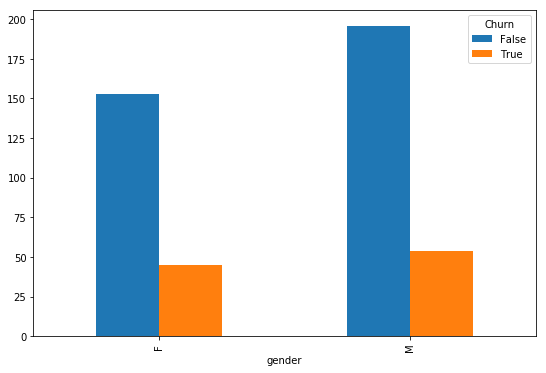

In [267]:
plt.rcParams["figure.figsize"] = (9,6)
gender.pivot(index='gender', columns='Churn', values = 'count(DISTINCT userId)').plot(kind='bar');

Chrun is higher number wise for the males, but if you see the group wise proportion then Females have higher chrun proportion

In [268]:
# Check distribution by Level
level_count = df.select(["userId", "level","Churn"]).dropDuplicates().groupby(["Churn", "level"]).count().toPandas()
level_count

,Churn,level,count
0,False,free,288
1,False,paid,246
2,True,paid,75
3,True,free,82


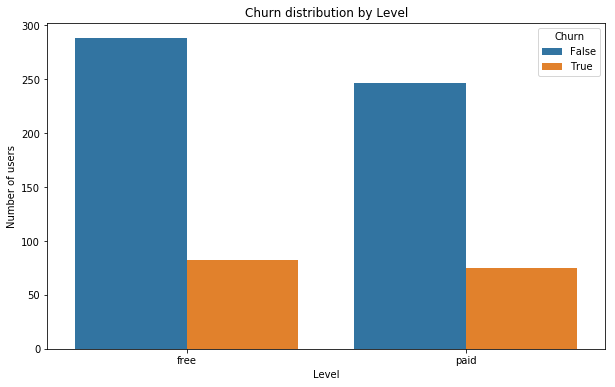

In [269]:
# Plot Churn distribution by Level
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="level", y="count", hue="Churn", data=level_count)
ax.set_title("Churn distribution by Level")
ax.set_xlabel("Level")
ax.set_ylabel("Number of users");

#### In the case of the 2 possible levels, the number of churns is similarly distributed between the 2 groups: 23,4% churn for paid customers and 22,2% churn for free customers.

In [270]:
# Exploring activitiy-related variables aggregated on label (churn)
df.groupby(df.Churn, df.auth).agg(countDistinct('sessionId')).show()

+-----+---------+-------------------------+
|Churn|     auth|count(DISTINCT sessionId)|
+-----+---------+-------------------------+
| true|Cancelled|                       97|
|false|Logged In|                     3861|
| true|Logged In|                     1072|
+-----+---------+-------------------------+



In [271]:
# check the chrun proportion grouping by length
df.groupby(df.Churn).agg(avg('itemInSession')).show()

+-----+------------------+
|Churn|avg(itemInSession)|
+-----+------------------+
| true| 107.5093008895664|
|false|107.84486484321059|
+-----+------------------+



In [272]:
df.groupby(df.Churn).agg(avg('length')).show()

+-----+------------------+
|Churn|       avg(length)|
+-----+------------------+
| true|248.99398360601663|
|false|248.58486352452857|
+-----+------------------+



In [273]:
#method wise chrun proportion
df.groupby(df.Churn, df.method).agg(countDistinct('sessionId')).show()

+-----+------+-------------------------+
|Churn|method|count(DISTINCT sessionId)|
+-----+------+-------------------------+
|false|   PUT|                     3791|
| true|   PUT|                     1046|
|false|   GET|                     3683|
| true|   GET|                     1028|
+-----+------+-------------------------+



In [274]:
# getting the page wise aggregation of uses based on sessions
page = df.groupby(df.page, df.Churn).agg(countDistinct('sessionId')).sort('page', 'Churn').toPandas()

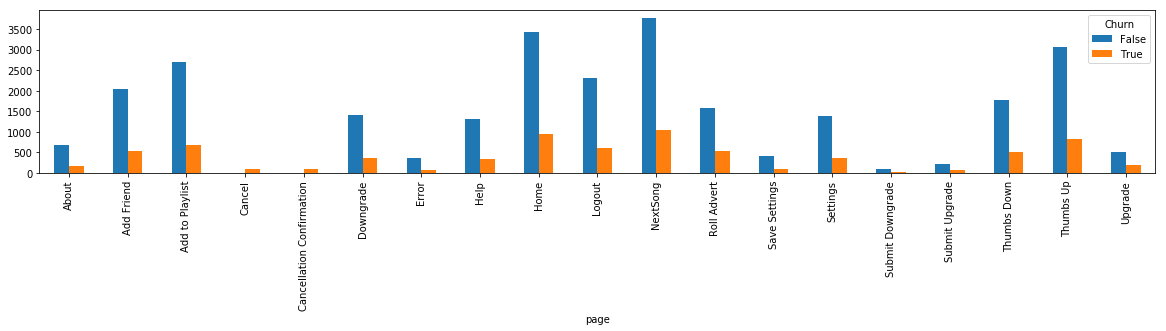

In [275]:
# Plotting page wise Chrun proportions for the users
plt.rcParams["figure.figsize"] = (20,3)
page.pivot(index='page', columns='Churn', values = 'count(DISTINCT sessionId)').plot(kind='bar');

In [276]:
pagedf = page.groupby(['page', 'Churn'])['count(DISTINCT sessionId)'].sum()
page_pcts = pagedf.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

In [277]:
# proportion of page wise churn
page_pcts

page                       Churn
About                      False     81.084337
                           True      18.915663
Add Friend                 False     79.658385
                           True      20.341615
Add to Playlist            False     79.591232
                           True      20.408768
Cancel                     True     100.000000
Cancellation Confirmation  True     100.000000
Downgrade                  False     79.431818
                           True      20.568182
Error                      False     81.431767
                           True      18.568233
Help                       False     79.854369
                           True      20.145631
Home                       False     78.470320
                           True      21.529680
Logout                     False     79.030595
                           True      20.969405
NextSong                   False     78.337479
                           True      21.662521
Roll Advert                

#### Difficult to see a clear relationship between visited page and churn
#### Roll Avert, Submit Downgrade/Upgrade, Thumbs down, Upgrade seem to have stronger relationship with Churn than other page visits

In [278]:
# lets check the distribution by Location - state
# Create 'state' column from spliting using 'location' information
df = df.withColumn('state', split(col('location'),',').getItem(1))

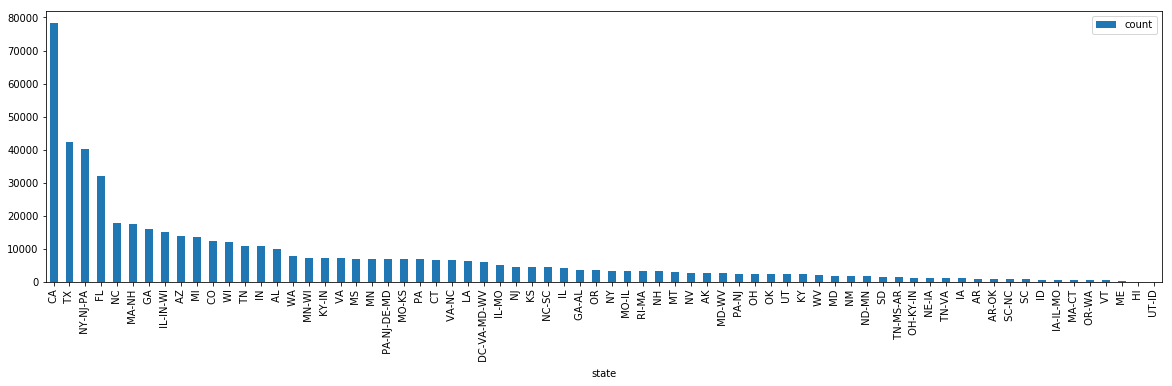

In [279]:

# Calculate the number of users in each state
users_per_state = df.select(['userId','state']).groupby('state').count().sort('count',ascending=False).toPandas()
users_per_state.plot(x = 'state', kind='bar',figsize=(20,5));

In [280]:
# Check distribution by Location - state
users_per_state = df.select(["userId", "state","Churn"]).dropDuplicates().groupby(["Churn", "state"]).count().sort('count','state', ascending = False).toPandas()
users_per_state.head(25)

,Churn,state,count
0,False,CA,52
1,False,TX,31
2,False,NY-NJ-PA,22
3,False,FL,20
4,False,IL-IN-WI,12
5,True,CA,10
6,False,WA,8
7,True,NY-NJ-PA,8
8,False,NC,8
9,False,MI,8


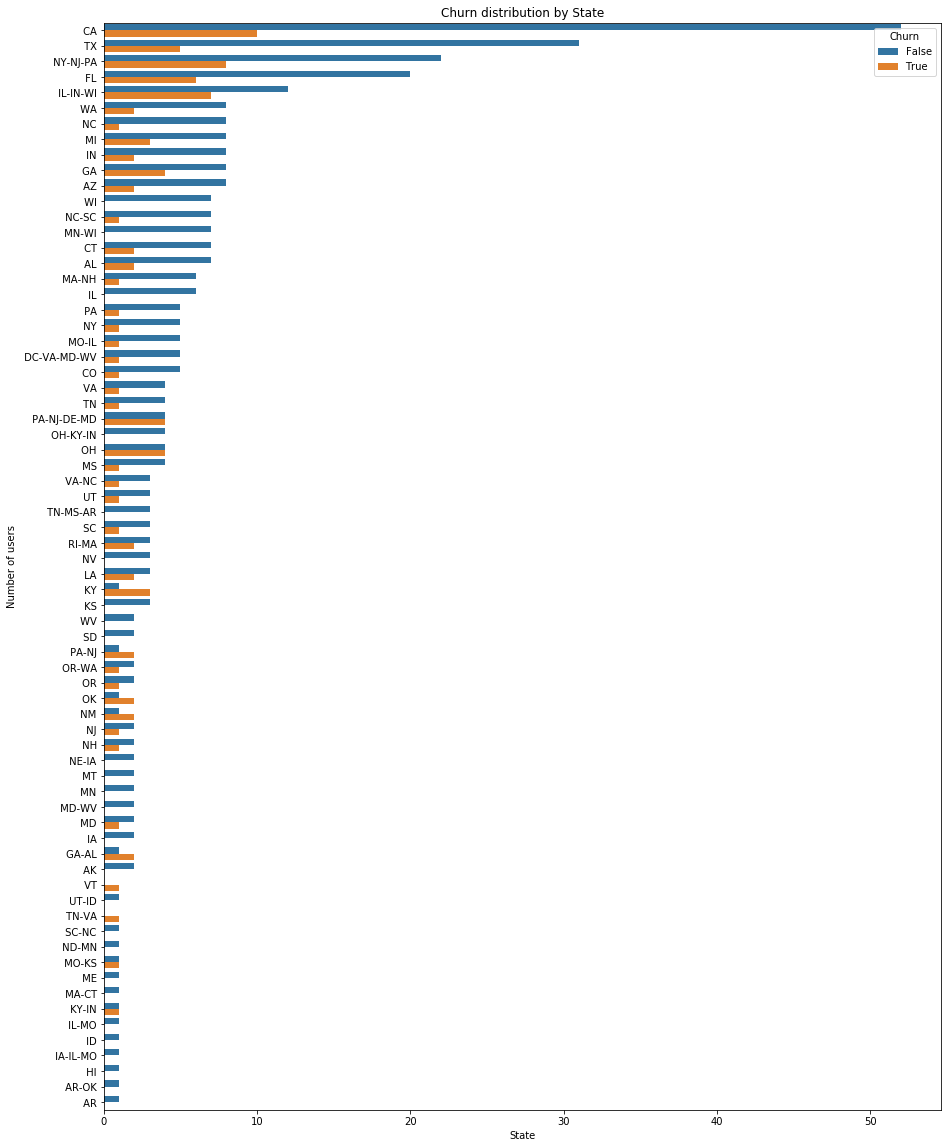

In [281]:
# Plot Churn distribution by Level
plt.figure(figsize=(15, 20))
ax = sns.barplot(x="count", y="state", hue="Churn", data = users_per_state)
ax.set_title("Churn distribution by State")
ax.set_xlabel("State")
ax.set_ylabel("Number of users");

The churn rate differs between the different states. In the top 4 states with the most users, the churn percentages are:

California (CA) - 16%
Texas (TX) - 14%
Florida (FL) - 23%
New York/New Jersey (NY-NJ-PA) - 27%
According to the bar graph most states have low Churn Rates like Illinois (IL), Connecticut,North and South Carolina, Nevada and Virginia.

A few examples have Churn Rate equals to 50% are: Ohio, Missouri and Kansas

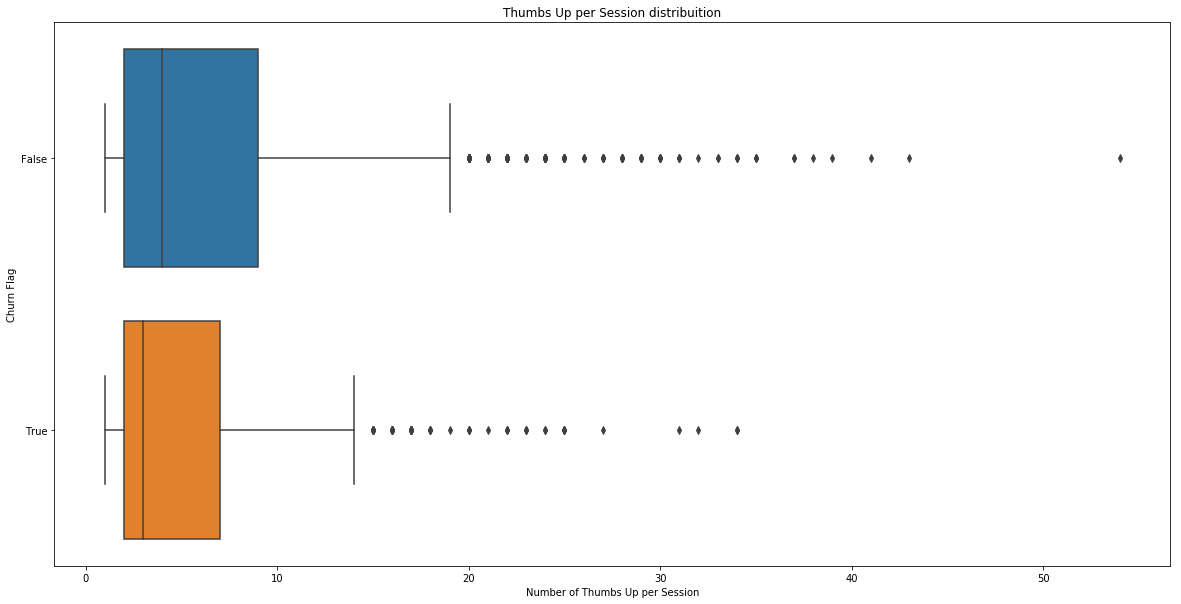

In [282]:
# Compare the number of Thumbs Up activity for active and churned users

thumbsup_count = df.filter(df['page'] == 'Thumbs Up').groupby("Churn", "sessionId").count().toPandas()


# Plot Thumbs Up activity per session for both segments

plt.figure(figsize=(20, 10))
ax = sns.boxplot(x='count', y='Churn', orient="h", data = thumbsup_count)
ax.set_title("Thumbs Up per Session distribuition")
ax.set_xlabel("Number of Thumbs Up per Session")
ax.set_ylabel("Churn Flag");

Customers who cancel/churn tend to give less Thumbs Up per session than active customers. This can be concluded because the limit values of all quadrants are lower (mean, median and maximum value)

In [283]:
## Functions for feature engineering  

def generate_int_label(df):
    df = df.withColumn('label', df['Churn'].cast(IntegerType()))
    return df



In [284]:
def calculate_tenure(df):
    '''
    Calculate tenure: the last interacted date - registration date
    '''
    max_ts_df = df.groupBy('userId').agg(max('ts').alias('max_ts'))
    df = df.join(max_ts_df, on=['userId'], how = 'left')
    df = df.withColumn('tenure', ((df.max_ts-df.registration)/86400000).cast(IntegerType()))    
    
    return df

In [285]:
def create_device_variables(df):
    
    get_browser = udf(lambda x: parse(x).browser.family)
    get_os = udf(lambda x: parse(x).os.family)
    get_device = udf(lambda x: parse(x).device.family)
    df = df.withColumn('browser', get_browser(df.userAgent))
    df = df.withColumn('os', get_os(df.userAgent))
    df = df.withColumn('device', get_device(df.userAgent))
    
    return df

In [286]:
def calculate_user_stats(df):
    '''
    Create user level stats
    '''
    w = Window.partitionBy(df.userId)
    df = df.withColumn('num_songs', approx_count_distinct(df.song).over(w))
    df = df.withColumn('num_artists', approx_count_distinct(df.artist).over(w))
    df = df.withColumn('avg_length', avg(df.length).over(w))
    
    return df

In [287]:
def create_page_variables(df):
    '''
    Based on EDA, create variables indicating if a user visited specific pages
    In addition to the pages that show stronger relationship with churn, 
    we will make variables for Add Friend and Add to Playlist page visits
    '''
    
    RollAdvert = df.where(df.page == 'Roll Advert').select('userId').distinct()
    RollAdvert_list = list(RollAdvert.select('userId').toPandas()['userId'])
    df = df.withColumn('roll_advert', df.userId.isin(RollAdvert_list))
    
    Downgrade = df.where(df.page == 'Submit Downgrade').select('userId').distinct()
    Downgrade_list = list(Downgrade.select('userId').toPandas()['userId'])
    df = df.withColumn('downgrade', df.userId.isin(Downgrade_list))
    
    Upgrade = df.where(df.page == 'Submit Upgrade').select('userId').distinct()
    Upgrade_list = list(Upgrade.select('userId').toPandas()['userId'])
    df = df.withColumn('upgrade', df.userId.isin(Upgrade_list))
   
    Thumbsdown = df.where(df.page == 'Thumbs Down').select('userId').distinct()
    Thumbsdown_list = list(Thumbsdown.select('userId').toPandas()['userId'])
    df = df.withColumn('thumbsdown', df.userId.isin(Thumbsdown_list))
    
    AddFriend = df.where(df.page == 'Add Friend').select('userId').distinct()
    AddFriend_list = list(AddFriend.select('userId').toPandas()['userId'])
    df = df.withColumn('addfriend', df.userId.isin(AddFriend_list))
    
    AddtoPlaylist = df.where(df.page == 'Add to Playlist').select('userId').distinct()
    AddtoPlaylist_list = list(AddtoPlaylist.select('userId').toPandas()['userId'])
    df = df.withColumn('addtoplaylist', df.userId.isin(AddtoPlaylist_list))
    
    return df

In [288]:
df = generate_int_label(df)

In [289]:
df = calculate_tenure(df)

In [290]:
df = create_device_variables(df)

In [291]:
df = calculate_user_stats(df)

In [292]:
df = create_page_variables(df)

In [293]:
pd.DataFrame(df.take(5), columns=df.columns).head()

,userId,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,...,device,num_songs,num_artists,avg_length,roll_advert,downgrade,upgrade,thumbsdown,addfriend,addtoplaylist
0,100010,Darude,Logged In,Darianna,F,0,Carpenter,226.08934,free,"Bridgeport-Stamford-Norwalk, CT",...,iPhone,99,92,269.48907,True,False,False,True,True,True
1,100010,Justice,Logged In,Darianna,F,1,Carpenter,285.41342,free,"Bridgeport-Stamford-Norwalk, CT",...,iPhone,99,92,269.48907,True,False,False,True,True,True
2,100010,Five Iron Frenzy,Logged In,Darianna,F,2,Carpenter,236.09424,free,"Bridgeport-Stamford-Norwalk, CT",...,iPhone,99,92,269.48907,True,False,False,True,True,True
3,100010,Carpenters,Logged In,Darianna,F,3,Carpenter,250.25261,free,"Bridgeport-Stamford-Norwalk, CT",...,iPhone,99,92,269.48907,True,False,False,True,True,True
4,100010,Uffie,Logged In,Darianna,F,4,Carpenter,227.52608,free,"Bridgeport-Stamford-Norwalk, CT",...,iPhone,99,92,269.48907,True,False,False,True,True,True


In [294]:
def drop_columns(df):
    '''
    Drop unnecessary columns before modeling
    '''
    columns_to_drop = ['userId', 'artist', 'auth', 'firstName', 'itemInSession', 'lastName', 'length', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status',
                       'ts', 'userAgent', 'max_ts', 'Churn']
    
    df = df.drop(*columns_to_drop) 
    
    return df

In [295]:
df_model = drop_columns(df)

In [296]:
pd.DataFrame(df_model.orderBy(rand()).take(5), columns=df_model.columns)

,gender,level,state,label,tenure,browser,os,device,num_songs,num_artists,avg_length,roll_advert,downgrade,upgrade,thumbsdown,addfriend,addtoplaylist
0,F,paid,CA,0,64,Safari,Mac OS X,Mac,1492,1152,249.904794,True,False,True,True,True,True
1,M,paid,FL,0,137,Firefox,Windows,Other,1553,1133,249.411717,True,False,True,True,True,True
2,F,paid,MO-IL,0,98,Chrome,Windows,Other,841,642,254.417364,True,False,True,True,True,True
3,F,free,NC,0,89,Chrome,Windows,Other,124,109,234.483802,True,False,False,False,False,True
4,F,paid,KY-IN,1,80,Chrome,Windows,Other,4962,3044,248.925711,True,True,True,True,True,True


## Building the model

The Algorithms we would be using are machine learning pipelines using Logistic Regression, Random Forest Classifier, and Gradient Boosted Tree Classifier.
Before that dataset needs to be Split into training and validation sets and necessary data transformation will be done

In [298]:
# Train test split
train, test = df_model.randomSplit([0.75, 0.25], seed=42)

In [299]:
# Buliding the Machine learning Pipeline
# String Indexer for OneHotEncoderEstimator
SI_gender = StringIndexer(inputCol='gender', outputCol='gender_index')
SI_level = StringIndexer(inputCol='level', outputCol='level_index')
SI_state = StringIndexer(inputCol='state', outputCol='state_index')
SI_browser = StringIndexer(inputCol='browser', outputCol='browser_index')
SI_os =  StringIndexer(inputCol='os', outputCol='os_index')
SI_device= StringIndexer(inputCol='device', outputCol='device_index')

# OneHotEncoderEstimator
OHE = OneHotEncoderEstimator(inputCols=['gender_index', 'level_index', 'state_index', 'browser_index', 'os_index', 'device_index'],
                             outputCols=['gender_OHE', 'level_OHE', 'state_OHE', 'browser_OHE', 'os_OHE', 'device_OHE'])

# Create a vector of all numeric features for scaling
num_assembler = VectorAssembler(inputCols=['tenure', 'num_songs', 'num_artists', 'avg_length'], outputCol='NumFeatures')

# Standard scaler for numeric features
scaler = StandardScaler(inputCol='NumFeatures', outputCol='ScaledNumFeatures', withStd=True)

# Create a vector of all features for modeling
feature_assembler = VectorAssembler(inputCols=['ScaledNumFeatures', 'gender_OHE', 'level_OHE', 'state_OHE', 'browser_OHE', 'os_OHE', 'device_OHE', 
                                              'roll_advert', 'downgrade', 'upgrade', 'thumbsdown', 'addfriend', 'addtoplaylist'], 
                                    outputCol='features')

# Logistic model
lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_pipeline = Pipeline(stages=[SI_gender, SI_level, SI_state, SI_browser, SI_os, SI_device, OHE, num_assembler, scaler, feature_assembler, lr])

# Random Forest
rf = RandomForestClassifier(featuresCol='features', labelCol='label')
rf_pipeline = Pipeline(stages=[SI_gender, SI_level, SI_state, SI_browser, SI_os, SI_device, OHE, num_assembler, scaler, feature_assembler, rf])

# Gradient.Boosted tree classifier
gbt = GBTClassifier(featuresCol='features', labelCol='label')
gbt_pieline = Pipeline(stages=[SI_gender, SI_level, SI_state, SI_browser, SI_os, SI_device, OHE, num_assembler, scaler, feature_assembler, gbt])


In [300]:
# Train and Validation

lr_model = lr_pipeline.fit(train)
rf_model = rf_pipeline.fit(train)
gbt_model = gbt_pieline.fit(train)

In [301]:
# obtain predictions
lr_preds = lr_model.transform(test)
rf_preds = rf_model.transform(test)
gbt_preds = gbt_model.transform(test)

### Model Evaluation


In [302]:
# Lets now evaluate our model and check the AUC, Accuracy and Evaluation matrix on all three algorithms
my_eval = BinaryClassificationEvaluator(labelCol = 'label')
print('AUC for Logistic Regression is {}'.format(my_eval.evaluate(lr_preds)))

AUC for Logistic Regression is 0.8591037476741336


In [303]:
print('AUC for Random Forest is {}'.format(my_eval.evaluate(rf_preds)))

AUC for Random Forest is 0.9410915066306828


In [304]:
print('AUC for Grandient Boosted Tree is {}'.format(my_eval.evaluate(gbt_preds)))

AUC for Grandient Boosted Tree is 0.9898280539673342


In [305]:
# Accuracy Score for Logistic Regression
print(lr_preds.filter(lr_preds.label == lr_preds.prediction).count())
print(lr_preds.count())

print('Accuracy for Linear Regression is {}'.format(89944/105513))

112370
131785
Accuracy for Linear Regression is 0.8524447224512619


In [308]:
# Accuracy score for Random Forest
print(rf_preds.filter(lr_preds.label == rf_preds.prediction).count())
print(rf_preds.count())

print('Accuracy for Random Forest is {}'.format(88488/105513))

109193
131785
Accuracy for Random Forest is 0.8386454749651702


In [309]:
# Accuracy score for Gradiant Boost tree

print(gbt_preds.filter(lr_preds.label == gbt_preds.prediction).count())
print(gbt_preds.count())

print('Accuracy for Gradient Boosted Tree is {}'.format(101481/105513))

126615
131785
Accuracy for Gradient Boosted Tree is 0.9617866992692844


In [310]:
## Confusion matrix for gbt
y_true = gbt_preds.select(['label']).collect()
y_pred = gbt_preds.select(['prediction']).collect()

In [311]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98    106055
           1       1.00      0.80      0.89     25730

   micro avg       0.96      0.96      0.96    131785
   macro avg       0.98      0.90      0.93    131785
weighted avg       0.96      0.96      0.96    131785



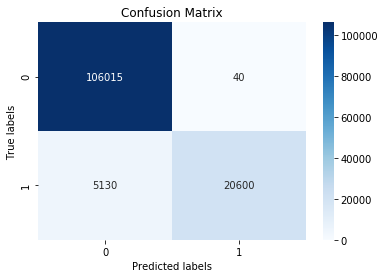

In [314]:
# PLot the Confusion matrix 
ax = plt.subplot()
conf = confusion_matrix(y_true, y_pred)
sns.heatmap(conf, annot=True, ax = ax, cmap='Blues', fmt='g')

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

### Lets tune the Hyperparameters

In [315]:
# Set the Parameters grid
gbt_paramGrid = (ParamGridBuilder()
                 .addGrid(gbt.maxDepth, [3, 5, 7])  
                 .addGrid(gbt.maxBins, [20, 60]) 
                 .addGrid(gbt.maxIter, [10, 20]) 
                 .build())

gbt_cv = CrossValidator(estimator=gbt_pieline, estimatorParamMaps=gbt_paramGrid, 
                        evaluator=my_eval, numFolds = 3)

In [ ]:
cvModel = gbt_cv.fit(train)